In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# %matplotlib notebook
from sklearn.cluster import KMeans

import sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os
from scipy.integrate import odeint
#change path to where 'manuscript_data' is saved
dir_path = '/home/antonio/Repositories/manuscript_data/'
sys.path.append(dir_path+'/code/utils/')
import operator_calculations as op_calc
import worm_dynamics as worm_dyn
import stats
from sklearn.linear_model import LinearRegression
colors_state_=plt.rcParams['axes.prop_cycle'].by_key()['color'][:10]
plt.rc('text', usetex=True)
plt.rc('font',size=14)

In [2]:
mat=h5py.File(dir_path+'Foraging/ForagingData/PNAS2011-DataStitched.mat','r')

refs=list(mat['#refs#'].keys())[1:]
tseries_w=[ma.masked_invalid(np.array(mat['#refs#'][ref]).T)[:,:5] for ref in refs]
mat.close()
frameRate=16.
dt=1/frameRate

masked_ts_w = []
for worm in np.arange(len(tseries_w)):
    ts_w = tseries_w[worm]
    ts_w[0] = ma.masked
    ts_w[-1] = ma.masked
    masked_ts_w.append(ts_w)

import worm_dynamics as worm_dyn
segments=op_calc.segment_maskedArray(ma.vstack(masked_ts_w),5)
omegas_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
a3s_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
for t0,tf in segments:
    phi,omega,a3=worm_dyn.compute_phi_omega_a3(ma.vstack(masked_ts_w),t0,tf)
    omegas_all[t0:tf] = omega
    a3s_all[t0:tf] = a3
omegas_all[omegas_all==0]=ma.masked
a3s_all[a3s_all==0]=ma.masked

f = h5py.File(dir_path+'Foraging/ForagingData/phspace_K_10_m_7.h5','r')
traj_matrix = ma.array(f['traj_matrix'])
phspace = ma.array(f['phspace'])
components = np.array(f['modes'])
f.close()

n_clusters=1000
f = h5py.File(dir_path+'Foraging/symbol_sequences/labels_{}_clusters.h5'.format(n_clusters))
labels_traj = ma.array(f['labels_traj'],dtype=int)
mask_traj = np.array(f['mask_traj'],dtype=bool)
labels_phspace = ma.array(f['labels_phspace'],dtype=int)
mask_phspace = np.array(f['mask_phspace'],dtype=bool)
centers_phspace = np.array(f['centers_phspace'])
centers_traj = np.array(f['centers_traj'])
f.close()

labels_traj[mask_traj] = ma.masked
labels_phspace[mask_phspace] = ma.masked

# Fig6B - ACF

In [3]:
f = h5py.File(dir_path+'Foraging/ForagingData/symbol_sequence_simulations.h5','r')
sims_w = []
for worm in range(len(tseries_w)):
    sims_w.append(np.array(f[str(worm)]['sims'],dtype=int))
f.close()

In [4]:
from joblib import Parallel, delayed

def get_random_state(traj,labels,sim):
    return np.vstack([traj[labels==state_idx][np.random.randint(np.sum(labels==state_idx))] for state_idx in sim])

In [5]:
traj_matrix[traj_matrix==0] = ma.masked
traj_matrix_w = []
labels_w = []
phspace_w = []
len_w = 33600
for kw in range(len(tseries_w)):
    traj_matrix_w.append(traj_matrix[kw*len_w:(kw+1)*len_w])
    labels_w.append(labels_traj[kw*len_w:(kw+1)*len_w])
    phspace_w.append(phspace[kw*len_w:(kw+1)*len_w])

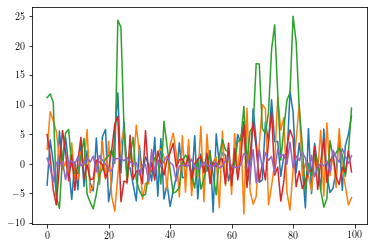

In [6]:
#example simulation
kw=0
sim_random = Parallel(n_jobs=50)(delayed(get_random_state)(traj_matrix_w[kw],labels_w[kw],sim)
                                            for sim in sims_w[kw][:10])

tseries_sim_random = [sim[:,:5] for sim in sim_random]

plt.plot(tseries_sim_random[9][:100])
plt.show()


In [7]:
delay = int(.75*frameRate)

lags_data = np.arange(0,161,1)
lags_sim = np.arange(0,int((160+delay)/delay),1)
n_modes=5
acf_data_w = np.zeros((len(tseries_w),n_modes,len(lags_data)))
acf_sims_w = np.zeros((len(tseries_w),len(sims_w[0]),n_modes,len(lags_sim)))
for kw in range(len(tseries_w)):
    sim_random = Parallel(n_jobs=25)(delayed(get_random_state)(traj_matrix_w[kw],labels_w[kw],sim)
                                                for sim in sims_w[kw])
    for mode_idx in range(n_modes):
        acf = stats.acf(tseries_w[kw][:,mode_idx],lags=lags_data)
        acf_data_w[kw,mode_idx] = acf

        tseries_sim_random = [sim[:,mode_idx] for sim in sim_random]

        acf_sim= []
        for ks,ts in enumerate(tseries_sim_random):
            acf = stats.acf(ts,lags=lags_sim)
            acf_sim.append(acf)
            acf_sims_w[kw,ks,mode_idx,:] = acf
        print(kw,mode_idx)

0 0
0 1
0 2
0 3
0 4


/home/antonio/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4
5 0
5 1
5 2
5 3
5 4
6 0
6 1
6 2
6 3
6 4
7 0
7 1
7 2
7 3
7 4
8 0
8 1
8 2
8 3
8 4
9 0
9 1
9 2
9 3
9 4
10 0
10 1
10 2
10 3
10 4
11 0
11 1
11 2
11 3
11 4


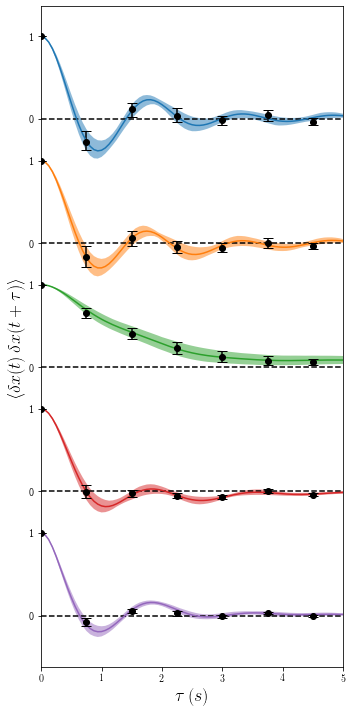

In [8]:
plt.figure(figsize=(5,10))
offset=1.5
for mode_idx in range(5):
#     plt.subplot(5,1,mode_idx+1)
    plt.axhline(-mode_idx*offset,ls='--',c='k')

    mean,cil,ciu = stats.bootstrap(acf_data_w[:,mode_idx,:],n_times=1000)
    plt.plot(lags_data*dt,mean-offset*mode_idx)
    plt.fill_between(lags_data*dt,cil-offset*mode_idx,ciu-offset*mode_idx,alpha=.5)

    mean,cil,ciu = stats.bootstrap(acf_sims_w.mean(axis=1)[:,mode_idx,:],n_times=1000)
    plt.errorbar(lags_sim*dt*delay,mean-offset*mode_idx,[mean-cil,ciu-mean],fmt='o',c='k',capsize=5)
    plt.xlim(0,5)
plt.ylabel(r'$\langle \delta x(t)\,\delta x(t+\tau)\rangle$',fontsize=18)
plt.xlabel(r'$\tau\,(s)$',fontsize=18)
plt.yticks(np.sort(np.hstack([np.arange(-5,1.1,1.5),np.arange(-6,0.1,1.5)])),[0,1]*5)

plt.tight_layout()
# plt.savefig('mode_acf_across_worms.pdf')
plt.show()

In [9]:
colors_state_=plt.rcParams['axes.prop_cycle'].by_key()['color'][:10]

In [10]:
def plot_hist_modes(tseries_sim_random,tseries_data,mode_idx,bins=50):
    if mode_idx==0:
        x_range = np.linspace(-18,18,bins)
    elif mode_idx == 1:
        x_range = np.linspace(-18,18,bins)
    elif mode_idx == 2:
        x_range = np.linspace(-30,30,bins)
    elif mode_idx == 3:
        x_range = np.linspace(-10,10,bins)
    elif mode_idx == 4:
        x_range = np.linspace(-7,7,bins)
        
    freqs_sim,bins_sim = np.histogram(ma.vstack(tseries_sim_random)[:,mode_idx].compressed(),bins=x_range)
    centers = (bins_sim[1:]+bins_sim[:-1])/2
    freqs_data,bins_data = np.histogram(tseries_data[:,mode_idx].compressed(),bins=x_range)
    bin_width = np.diff(centers)[0]
    
    plt.plot(centers,freqs_data/np.trapz(freqs_data),lw=5,c=colors_state_[mode_idx])
    plt.plot(centers,freqs_sim/np.trapz(freqs_sim),lw=5,c='k',ls='--')
    plt.fill_between(centers,np.zeros(len(freqs_data)),freqs_data/np.trapz(freqs_data),alpha=.7,color=colors_state_[mode_idx])
    # plt.xlim(-25,30)
    plt.ylim(0,)
    plt.xlabel('$a_1$',fontsize=15)
    plt.ylabel('PDF',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.xlim(x_range[0],x_range[-1])
    return freqs_data/np.trapz(freqs_data),freqs_sim/np.trapz(freqs_sim)

In [11]:
def plot_a1_a2(tseries_sim_random,tseries_data):
    xrange = [-10,10]
    yrange = [-10,10]
    r=5
    n_grid=150
    density=stats.density_plot(ma.vstack(tseries_sim_random)[:,0].compressed(),ma.vstack(tseries_sim_random)[:,1].compressed()
                         ,xrange,yrange,n_grid,n_grid,border=r,smooth=True)
    data_sim=density/density.sum()

    density=stats.density_plot(tseries_data[:,0].compressed(),tseries_data[:,1].compressed()
                         ,xrange,yrange,n_grid,n_grid,border=r,smooth=True)
    data_data=density/density.sum()

    vmax_ = np.max([np.percentile(data_sim,99.5),np.percentile(data_data,99.5)])
    
    import matplotlib.cm as cm
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)

    plt.title('Simulation')
    plt.imshow(data_sim , origin='lower', extent=[xrange[0], xrange[1], yrange[0], yrange[1]],cmap=cm.jet,
               aspect=1,vmin=0,vmax=vmax_)#,norm=colors.SymLogNorm(linthresh=4e-5, linscale=1e-7,vmin=0, vmax=13e-5)) #vmin=0.00004,vmax=.00011)#,vmin=40)#,vmax=6,vmin=0)#,norm=colors.SymLogNorm(linthresh=1e-2, linscale=1,vmin=data.min(), vmax=5))#
    plt.colorbar()
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('$a_1$',fontsize=15)
    plt.ylabel('$a_2$',fontsize=15)



    plt.subplot(1,2,2)
    plt.title('Data')

    plt.imshow(data_data , origin='lower', extent=[xrange[0], xrange[1], yrange[0], yrange[1]],cmap=cm.jet,
               aspect=1,vmin=0,vmax=vmax_)#,norm=colors.SymLogNorm(linthresh=4e-5, linscale=1e-7,vmin=0, vmax=13e-5))#,vmax=6,vmin=0)#,norm=colors.SymLogNorm(linthresh=1e-2, linscale=1,vmin=data.min(), vmax=5))#
    plt.colorbar()
    # plt.axis('equal')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('$a_1$',fontsize=15)
    plt.ylabel('$a_2$',fontsize=15)
    plt.tight_layout()

#     plt.savefig('Mode_1vs2_sim_worm_{}.pdf'.format(kw))
    plt.show()
    return data_sim,data_data

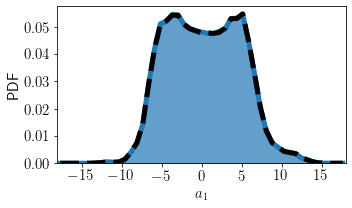

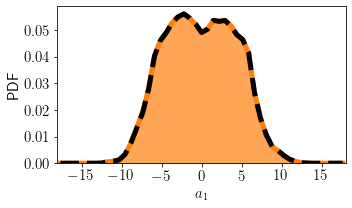

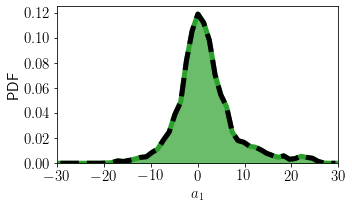

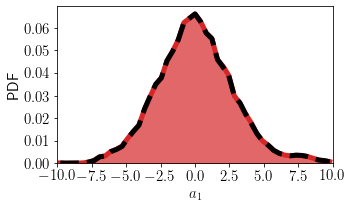

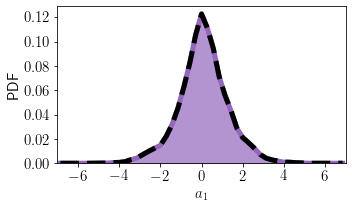

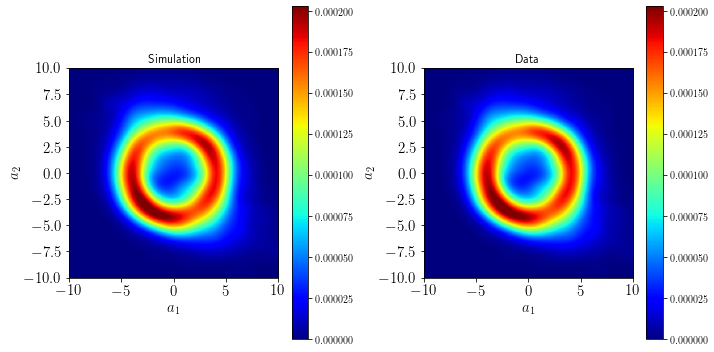

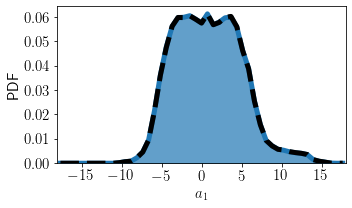

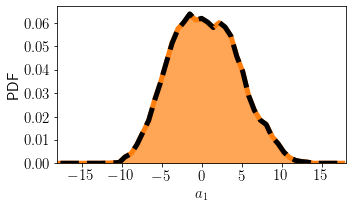

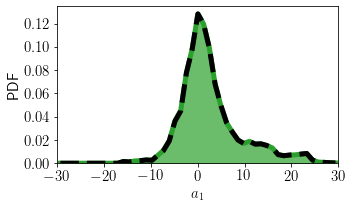

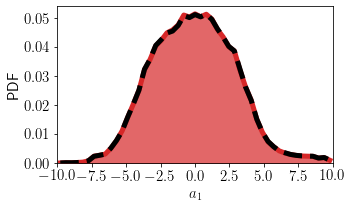

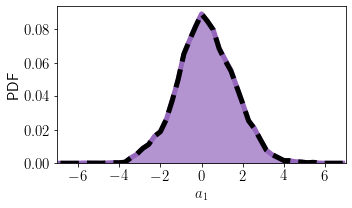

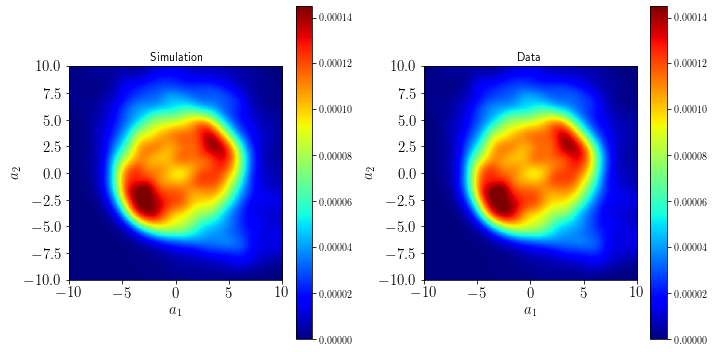

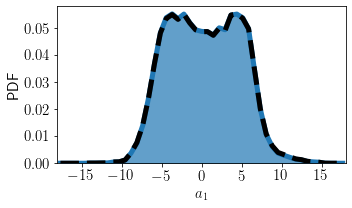

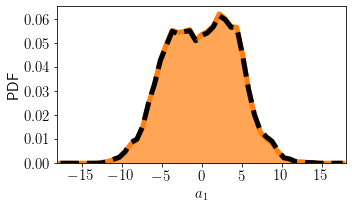

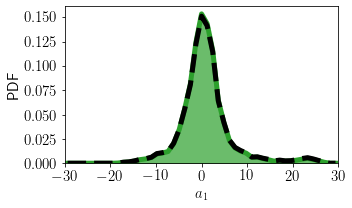

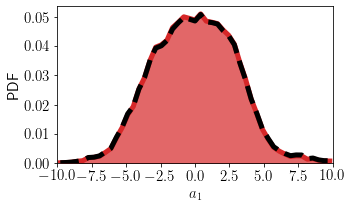

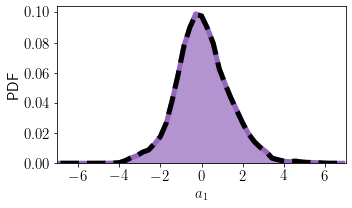

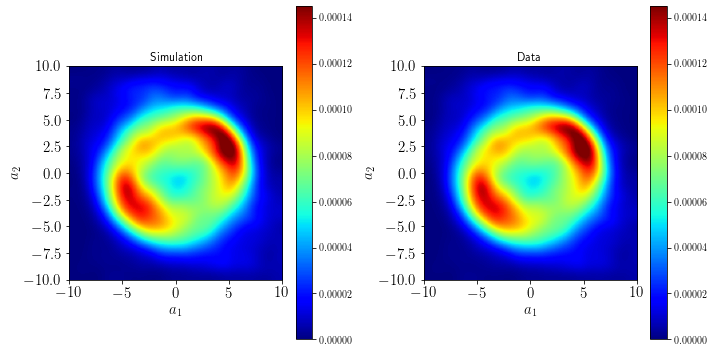

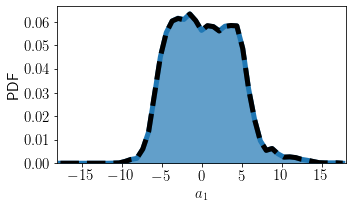

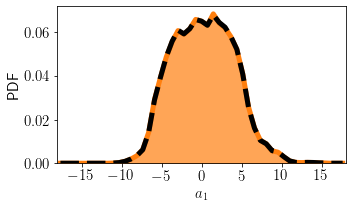

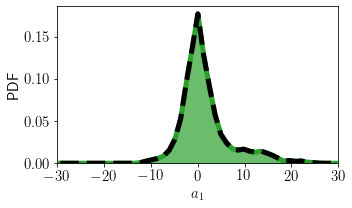

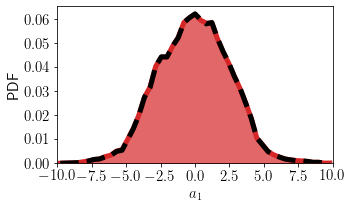

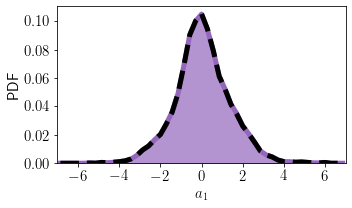

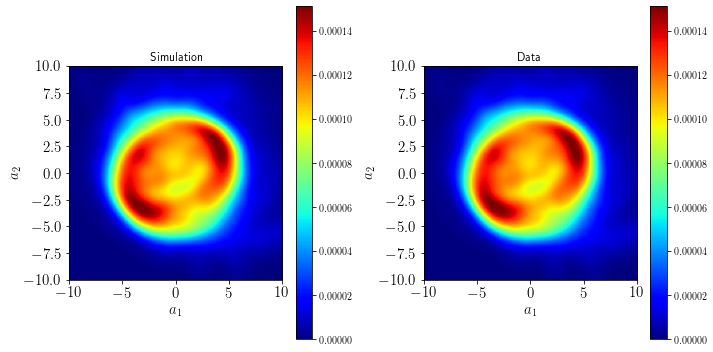

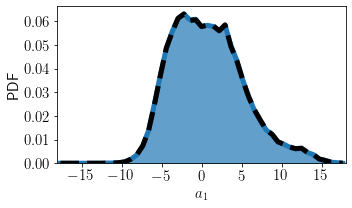

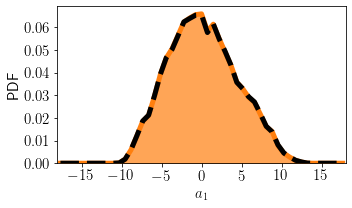

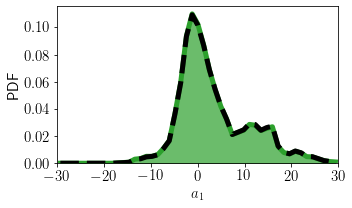

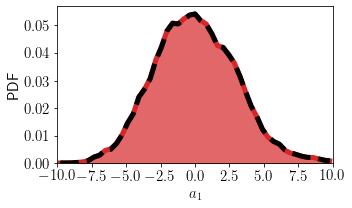

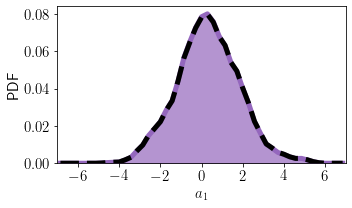

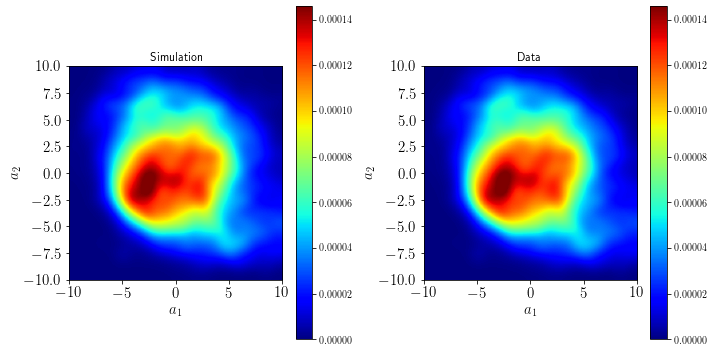

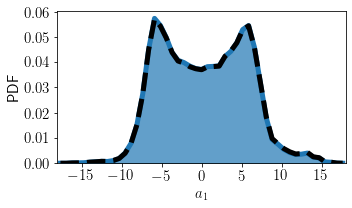

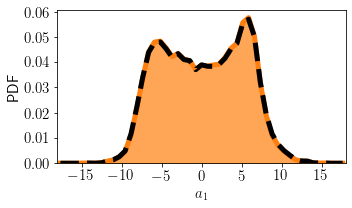

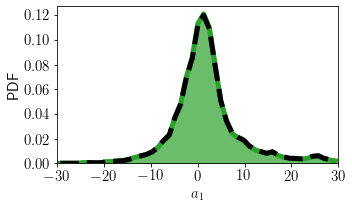

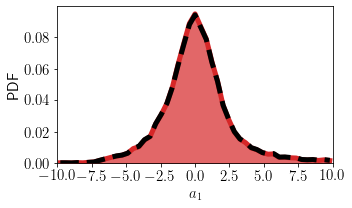

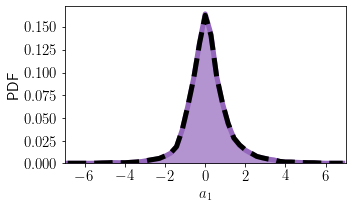

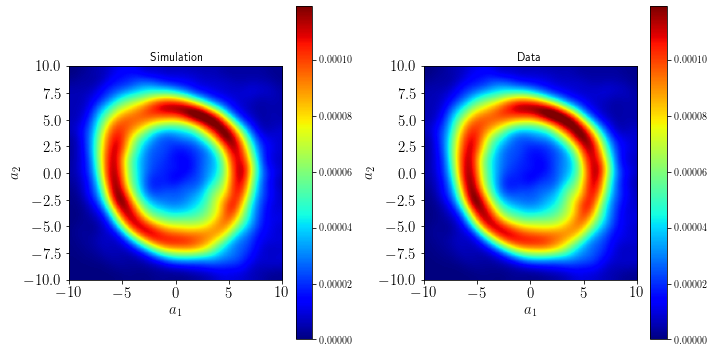

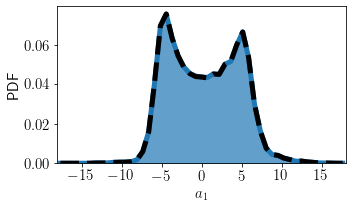

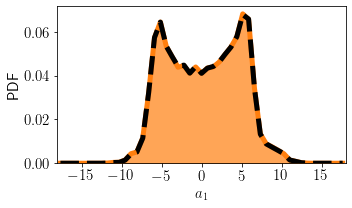

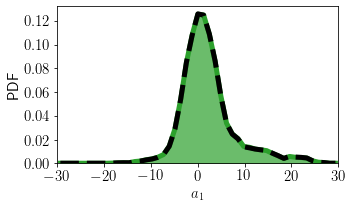

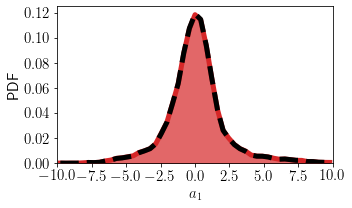

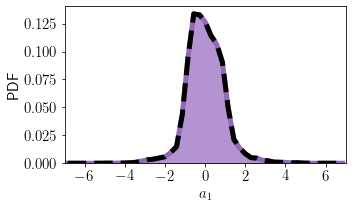

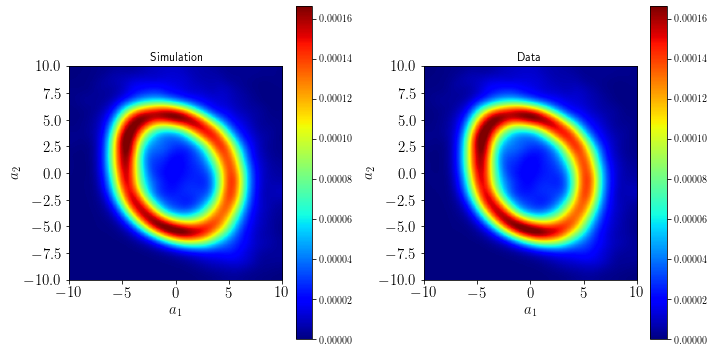

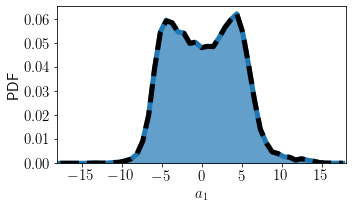

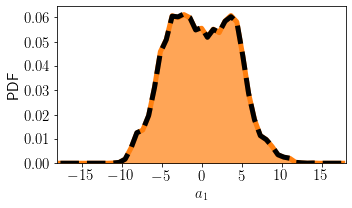

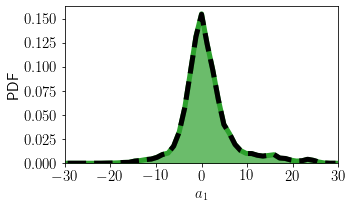

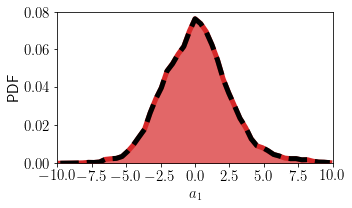

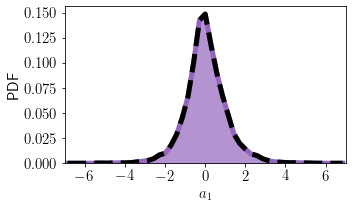

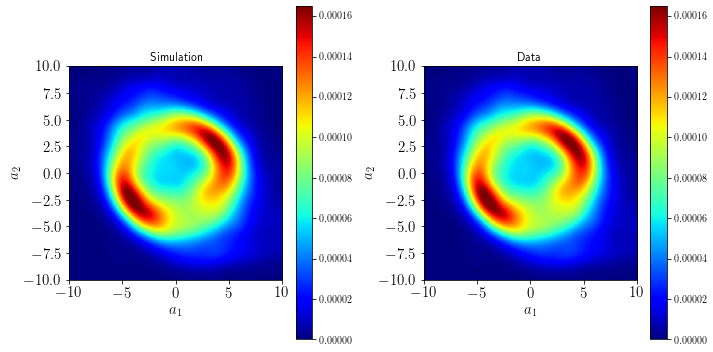

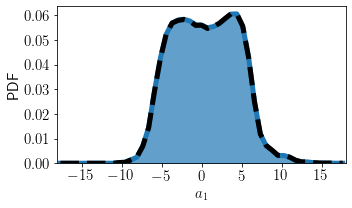

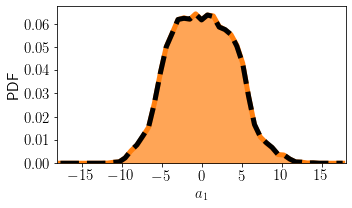

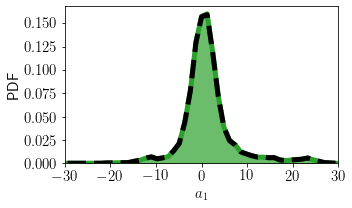

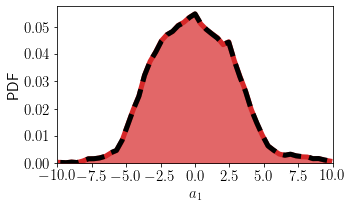

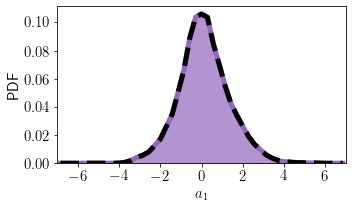

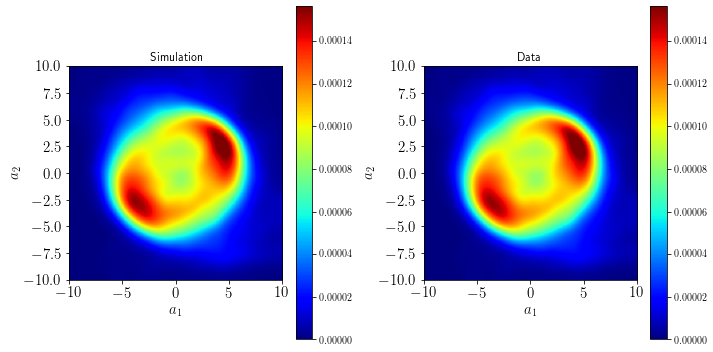

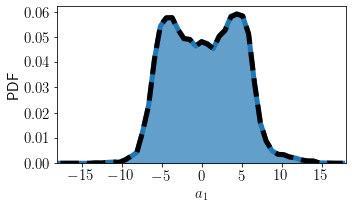

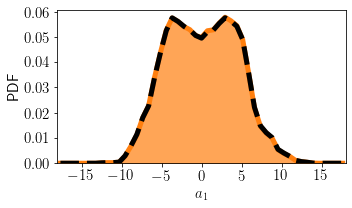

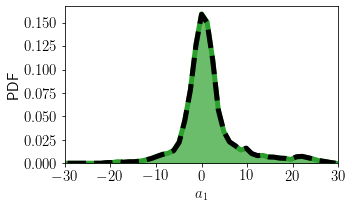

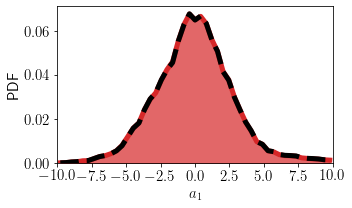

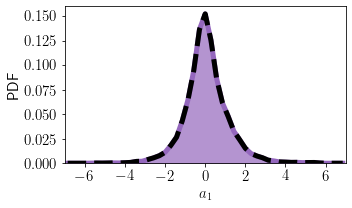

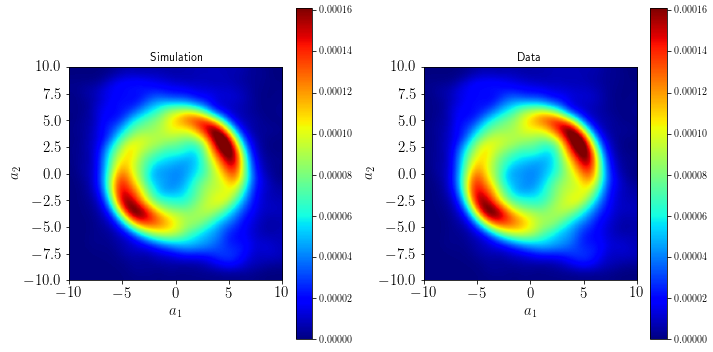

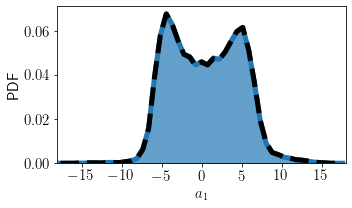

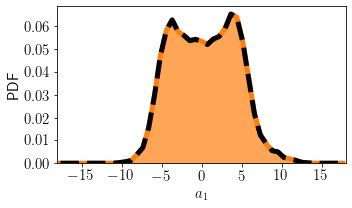

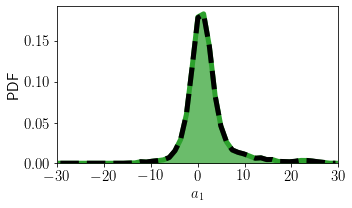

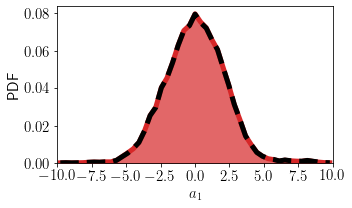

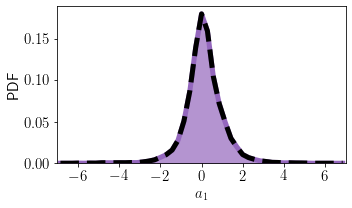

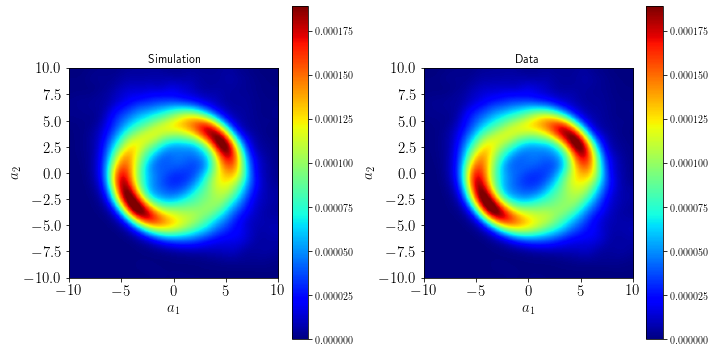

In [12]:
p_data_w=[]
p_sim_w=[]
p2d_data_w=[]
p2d_sim_w=[]
for kw in range(len(tseries_w)):
    sim_random = Parallel(n_jobs=25)(delayed(get_random_state)(traj_matrix_w[kw],labels_w[kw],sim)
                                            for sim in sims_w[kw])
    tseries_sim_random = [sim[:,:5] for sim in sim_random]

    p_data_mode = []
    p_sim_mode = []
    for mode_idx in range(5):
        plt.figure(figsize=(5,3))
        p_data,p_sim = plot_hist_modes(tseries_sim_random,tseries_w[kw],mode_idx)
        plt.tight_layout()
#         plt.savefig('mode_dist_worm_{}_mode_{}.pdf'.format(kw,mode_idx))
        plt.show()
        p_data_mode.append(p_data)
        p_sim_mode.append(p_sim)
    p_data_w.append(p_data_mode)
    p_sim_w.append(p_sim_mode)
    
    data_sim,data_data = plot_a1_a2(tseries_sim_random,tseries_w[kw])
    p2d_data_w.append(data_data)
    p2d_sim_w.append(data_sim)

In [13]:
def centers_mode(mode_idx,bins=50):
    if mode_idx==0:
        x_range = np.linspace(-18,18,bins)
    elif mode_idx == 1:
        x_range = np.linspace(-18,18,bins)
    elif mode_idx == 2:
        x_range = np.linspace(-30,30,bins)
    elif mode_idx == 3:
        x_range = np.linspace(-10,10,bins)
    elif mode_idx == 4:
        x_range = np.linspace(-7,7,bins)
    return x_range

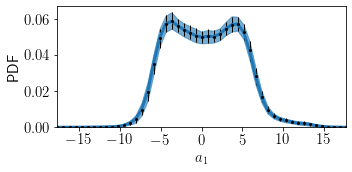

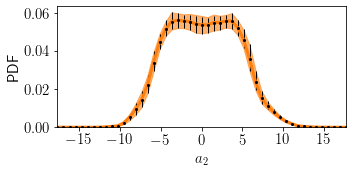

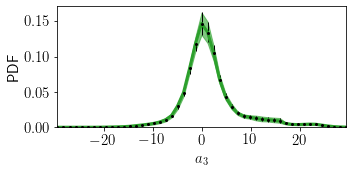

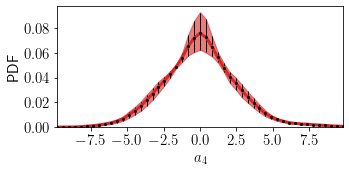

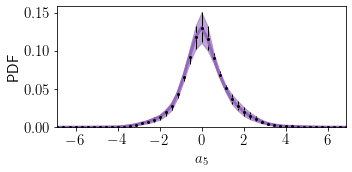

In [15]:
p_data_w = np.array(p_data_w)
p_sim_w = np.array(p_sim_w)
for mode_idx in range(5):
    plt.figure(figsize=(5,2.5))
    mean,cil,ciu = stats.bootstrap(p_data_w[:,mode_idx,:],n_times=1000)
    bins_= centers_mode(mode_idx)
    centers = (bins_[1:]+bins_[:-1])/2
    plt.plot(centers,mean,lw=3,c=colors_state_[mode_idx])
    plt.fill_between(centers,cil,ciu,alpha=.6,color=colors_state_[mode_idx])
    mean,cil,ciu = stats.bootstrap(p_sim_w[:,mode_idx,:],n_times=1000)
    bins_= centers_mode(mode_idx)
    centers = (bins_[1:]+bins_[:-1])/2
    # plt.plot(centers,mean,lw=3,ls='--',c='k')
    plt.errorbar(centers,mean,[mean-cil,ciu-mean],c='k',capsize=0,marker='o',ms=2,fmt='o',elinewidth=1)
    plt.ylim(0,)
    plt.xlabel('$a_{}$'.format(mode_idx+1),fontsize=15)
    plt.ylabel('PDF',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.xlim(centers[0],centers[-1])
#     plt.savefig('mode_dist_all_worms_mode_{}_errorbars.pdf'.format(mode_idx))

    plt.show()